#Project Code


---


## Task 1 training Resnet-18 ( CNN ) Model on Colorectal cancer dataset.

###Imports

In [51]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import time
from typing_extensions import Self
from scipy import stats
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.metrics import multilabel_confusion_matrix
from torchvision.models import resnet18
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [2]:
pip install thop

In [3]:
from thop import profile

### Importing datasets from github.

In [4]:
!wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
import colab_github
colab_github.github_auth(persistent_key=True)

# method to import git data into colab taken from:
# https://github.com/tsunrise/colab-github

Mounted at /content/drive/
Looks that a private key is already created. If you have already push it to github, no action required.
 Otherwise, Please go to https://github.com/settings/ssh/new to upload the following key: 
ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAIKsdgQltK+JTZbl5J1o7j408pGhjNyf4YUbWJmSugvZz root@b884b6fcbf02

Please use SSH method to clone repo.


cloning

In [5]:
!git clone git@github.com:jonq-q/Comp432-GroupQ.git

Cloning into 'Comp432-GroupQ'...
remote: Enumerating objects: 18096, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 18096 (delta 16), reused 0 (delta 0), pack-reused 18054
Receiving objects: 100% (18096/18096), 1.14 GiB | 19.51 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Updating files: 100% (18018/18018), done.


### Data Onboarding

In [6]:
dataset = datasets.ImageFolder("/content/Comp432-GroupQ/Dataset 1/Colorectal Cancer /", transforms.Compose([
        torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))

train_set, test_set = torch.utils.data.random_split(dataset,[0.7,0.3])                # splits dataset into specified ratios
train_loader = DataLoader(train_set,shuffle=True,batch_size=32, num_workers=0)         # create train loader
test_loader = DataLoader(test_set,batch_size=32, num_workers=0)  # create test loader

### Model 1 creation: Resnet - 18: CNN (no pretraining)

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

if torch.cuda.is_available():
    model = model.to('cuda')

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model training

In [8]:
num_epochs = 20
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    current_loss = 0.0
    correct = 0
    total = 0
    round = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        y_pred = model(inputs)
        l = loss(y_pred, labels)
        l.backward()
        optimizer.step()

        current_loss += l.item()
        _, predicted = torch.max(y_pred.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training time for one epoch: {elapsed_time} seconds")
    train_accuracy = 100 * correct / total
    train_loss = current_loss / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

Training time for one epoch: 46.982632875442505 seconds
Epoch 1/20, Loss: 1.4368, Accuracy: 72.24%
Training time for one epoch: 40.50851559638977 seconds
Epoch 2/20, Loss: 0.4603, Accuracy: 82.79%
Training time for one epoch: 39.70610451698303 seconds
Epoch 3/20, Loss: 0.3795, Accuracy: 84.74%
Training time for one epoch: 41.08207106590271 seconds
Epoch 4/20, Loss: 0.3168, Accuracy: 87.64%
Training time for one epoch: 38.17673349380493 seconds
Epoch 5/20, Loss: 0.2735, Accuracy: 89.95%
Training time for one epoch: 42.29413938522339 seconds
Epoch 6/20, Loss: 0.2489, Accuracy: 91.05%
Training time for one epoch: 38.5475435256958 seconds
Epoch 7/20, Loss: 0.2409, Accuracy: 90.93%
Training time for one epoch: 39.25230956077576 seconds
Epoch 8/20, Loss: 0.2004, Accuracy: 92.57%
Training time for one epoch: 38.34820032119751 seconds
Epoch 9/20, Loss: 0.1996, Accuracy: 92.81%
Training time for one epoch: 38.80532932281494 seconds
Epoch 10/20, Loss: 0.1898, Accuracy: 92.81%
Training time for o

Flop calculation

In [9]:
# Input tensor (batch size, channels, height, width)
input_tensor = torch.randn(1, 3, 224, 224).to('cuda')

flops, params = profile(model, inputs=(input_tensor,))

print(f"Number of FLOPs: {flops / 1e9} G FLOPs")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Number of FLOPs: 1.824033792 G FLOPs


Code validation

In [10]:
val_loss = []

with torch.no_grad():
          model.eval()
          running_loss = 0.0
          running_score = 0.0
          for image,label in test_loader:
                image = image.to('cuda')
                label = label.to('cuda')
                optimizer.zero_grad()
                y_pred = model.forward(image)
                l = loss(y_pred,label)
                running_loss += l.item()

                val, index_ = torch.max(y_pred,axis=1)
                running_score += torch.sum(index_ == label.data).item()

          epoch_score = running_score/len(test_loader.dataset)
          epoch_loss = running_loss/len(test_loader.dataset)
          val_loss.append(epoch_loss)
          print("Validation loss: {}, accuracy: {}".format(epoch_loss,epoch_score))

          all_predictions = []
          true_labels = []
          for inputs, labels in test_loader:
              inputs, labels = inputs.to('cuda'), labels.to('cuda')
              outputs = model.forward(inputs)
              _, predicted = torch.max(outputs.data, 1)
              all_predictions.extend(predicted.cpu().numpy())
              true_labels.extend(labels.cpu().numpy())

classification_rep = classification_report(true_labels, all_predictions, target_names=dataset.classes)
print(classification_rep)

Validation loss: 0.006389651906210929, accuracy: 0.9255555555555556
              precision    recall  f1-score   support

         MUS       0.98      0.79      0.87       599
        NORM       0.99      0.99      0.99       594
         STR       0.82      0.98      0.89       607

    accuracy                           0.92      1800
   macro avg       0.93      0.92      0.92      1800
weighted avg       0.93      0.92      0.92      1800



Saving trained model (note: may require adjusting directories depending on your drive)

In [11]:
torch.save(model.state_dict(), '/content/drive/My Drive/TrainedModel')

In [12]:
pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

#RostislavRu
#pretrained_model.load_state_dict(torch.load('/content/drive/My Drive/Comp 432/TrainedModel', map_location=torch.device('cuda')),strict=False)

#Jonq-q
pretrained_model.load_state_dict(torch.load('/content/drive/My Drive/TrainedModel', map_location=torch.device('cuda')),strict=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


_IncompatibleKeys(missing_keys=[], unexpected_keys=['total_ops', 'total_params', 'layer1.0.total_ops', 'layer1.0.total_params', 'layer1.1.total_ops', 'layer1.1.total_params', 'layer2.0.total_ops', 'layer2.0.total_params', 'layer2.1.total_ops', 'layer2.1.total_params', 'layer3.0.total_ops', 'layer3.0.total_params', 'layer3.1.total_ops', 'layer3.1.total_params', 'layer4.0.total_ops', 'layer4.0.total_params', 'layer4.1.total_ops', 'layer4.1.total_params'])

Checking model after saving

In [13]:
pretrained_model.to('cuda')

with torch.no_grad():
          pretrained_model.eval()
          all_predictions = []
          true_labels = []
          for inputs, labels in test_loader:
              inputs, labels = inputs.to('cuda'), labels.to('cuda')
              outputs = pretrained_model.forward(inputs)
              _, predicted = torch.max(outputs.data, 1)
              all_predictions.extend(predicted.cpu().numpy())
              true_labels.extend(labels.cpu().numpy())

classification_rep = classification_report(true_labels, all_predictions, target_names=dataset.classes)
print(classification_rep)

              precision    recall  f1-score   support

         MUS       0.98      0.75      0.85       599
        NORM       0.98      0.99      0.99       594
         STR       0.80      0.98      0.88       607

    accuracy                           0.91      1800
   macro avg       0.92      0.91      0.91      1800
weighted avg       0.92      0.91      0.91      1800



Confusion matrix

In [14]:
confMatrix = multilabel_confusion_matrix(true_labels, all_predictions, labels=[0, 1, 2])
print(confMatrix)

[[[1194    7]
  [ 147  452]]

 [[1197    9]
  [   4  590]]

 [[1045  148]
  [  13  594]]]


Model layers

In [ ]:
pretrained_model

### Model visualization on Dataset 1 with t-SNE

### Approach 1

In [15]:
device=torch.device("cuda:0"if torch.cuda.is_available() else "cpu")

In [16]:
#print(list(pretrained_model.children()))
features=list(pretrained_model.children())[:-1] #only remove fc
model_out=nn.Sequential(*features).to(device)
def for_feature(loader):
  data_tmp=[]
  label_tmp=[]

  with torch.no_grad():
      for img,label in loader:
        img=img.to(device)

        output1=model_out(img)

        data_tmp.append(output1.cpu().numpy())
        label_tmp.append(label.cpu().numpy())

  return np.vstack(data_tmp), np.hstack(label_tmp)

In [17]:
trained_feature, trained_label=for_feature(train_loader)

In [18]:
trained_feature_n = trained_feature.reshape(4200,512)

In [19]:
stats.describe(trained_label)

DescribeResult(nobs=4200, minmax=(0, 2), mean=0.9980952380952381, variance=0.6653928939997052, skewness=0.003495506834209032, kurtosis=-1.4967624852399835)

In [20]:
tsne=TSNE(n_components=2, random_state=0, learning_rate='auto')
projections=tsne.fit_transform(trained_feature_n)
fig=px.scatter(projections[:,0], projections[:,1], color = trained_label, labels={"color":""})
fig.show()

### Approach 2

In [21]:
dataset1 = datasets.ImageFolder("/content/Comp432-GroupQ/Dataset 1/Colorectal Cancer ", transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))

dataloader_sc = DataLoader(dataset1, batch_size=64, shuffle=True)

In [23]:
features = list(pretrained_model.children())[:-1] #only remove fc
resnet_nohead = nn.Sequential(*features).to(device)
resnet_nohead = resnet_nohead.eval()

In [24]:
all_features = []
all_labels = []

resnet_nohead.to(device)

with torch.no_grad():
    for images, labels in dataloader_sc:
        images = images.to(device)
        labels = labels.to(device)
        features = resnet_nohead(images)
        features = features.squeeze().cpu().numpy()
        all_features.append(features)
        all_labels.append(labels.cpu().numpy())

# Concatenate features and labels
all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [25]:
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(all_features)

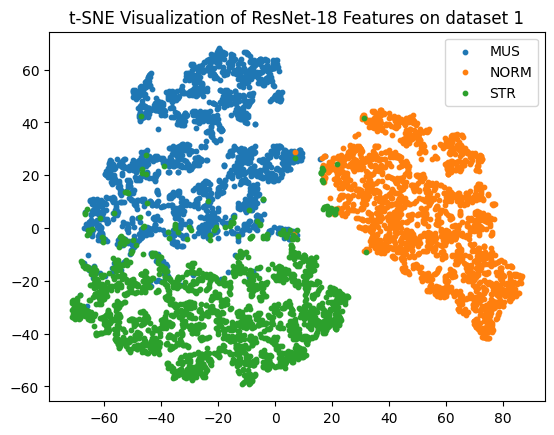

In [26]:
# Plot the t-SNE embeddings with different colors for each class
plt.scatter(embedded_features[all_labels == 0, 0], embedded_features[all_labels == 0, 1], label='MUS',s=10)
plt.scatter(embedded_features[all_labels == 1, 0], embedded_features[all_labels == 1, 1], label='NORM',s=10)
plt.scatter(embedded_features[all_labels == 2, 0], embedded_features[all_labels == 2, 1], label='STR',s=10)

plt.title('t-SNE Visualization of ResNet-18 Features on dataset 1')
plt.legend()
plt.show()

## Task 2: Pre-trained CNN applications on different datasets

###Scenario 1: Locally trained CNN applied to dataset 2, with KNN and SVM classification

In [27]:
#task 2 Pretrained ResNet18 applied to Dataset2 & 3
dataset2 = datasets.ImageFolder("/content/Comp432-GroupQ/Dataset 2/Prostate Cancer/", transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))

dataloader_sc1 = DataLoader(dataset2, batch_size=64, shuffle=True)

In [28]:
features = list(pretrained_model.children())[:-1] #only remove fc
resnet_nohead = nn.Sequential(*features).to(device)
resnet_nohead = resnet_nohead.eval()

model output extraction

In [29]:
all_features = []
all_labels = []

resnet_nohead.to(device)

with torch.no_grad():
    for images, labels in dataloader_sc1:
        images = images.to(device)
        labels = labels.to(device)
        features = resnet_nohead(images)
        features = features.squeeze().cpu().numpy()
        all_features.append(features)
        all_labels.append(labels.cpu().numpy())

# Concatenate features and labels
all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

t-SNE

In [30]:
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(all_features)

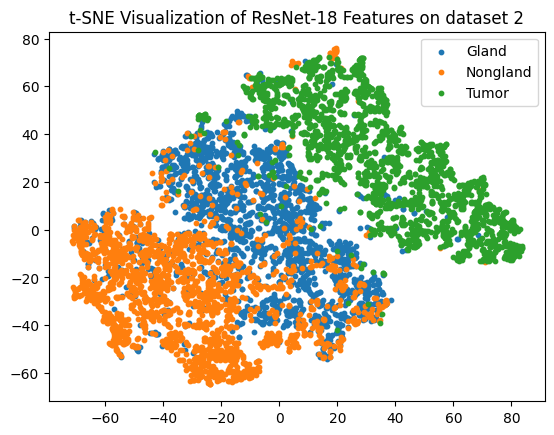

In [31]:
# Plot the t-SNE embeddings with different colors for each class
plt.scatter(embedded_features[all_labels == 0, 0], embedded_features[all_labels == 0, 1], label='Gland',s=10)
plt.scatter(embedded_features[all_labels == 1, 0], embedded_features[all_labels == 1, 1], label='Nongland',s=10)
plt.scatter(embedded_features[all_labels == 2, 0], embedded_features[all_labels == 2, 1], label='Tumor',s=10)

plt.title('t-SNE Visualization of ResNet-18 Features on dataset 2')
plt.legend()
plt.show()

### KNN classification

In [32]:
def extract_features(model, dataloader):
    model.eval()
    all_features, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            features = model(images)
            all_features.append(features.squeeze().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.vstack(all_features), np.array(all_labels)

# Extract features from the dataset
features, labels = extract_features(resnet_nohead, dataloader_sc1)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Create k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)

# Evaluate the model
accuracy = knn_classifier.score(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 89.39%


In [35]:
y_pred_knn = knn_classifier.predict(X_test)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84       582
           1       0.86      0.88      0.87       608
           2       0.97      0.97      0.97       610

    accuracy                           0.89      1800
   macro avg       0.89      0.89      0.89      1800
weighted avg       0.89      0.89      0.89      1800



In [36]:
confMatrix_knn = multilabel_confusion_matrix(y_test, y_pred_knn)
print(confMatrix_knn)

[[[1128   90]
  [  95  487]]

 [[1107   85]
  [  76  532]]

 [[1174   16]
  [  20  590]]]


### SVM Classification

In [37]:
svm_classifier = svm.SVC()
svm_classifier.fit(X_train, y_train)

# Evaluate the SVM model
y_pred_svm = svm_classifier.predict(X_test)

In [38]:
print("Classification Report (SVM):\n", classification_report(y_test, y_pred_svm))

Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.87      0.86      0.87       582
           1       0.89      0.89      0.89       608
           2       0.97      0.98      0.97       610

    accuracy                           0.91      1800
   macro avg       0.91      0.91      0.91      1800
weighted avg       0.91      0.91      0.91      1800



In [39]:
confMatrix_svm = multilabel_confusion_matrix(y_test, y_pred_svm)
print(confMatrix_svm)

[[[1142   76]
  [  79  503]]

 [[1124   68]
  [  66  542]]

 [[1174   16]
  [  15  595]]]


## Scenario 2: Locally trained CNN on Dataset 3

In [40]:
dataset3 = datasets.ImageFolder("/content/Comp432-GroupQ/Dataset 3/Animal Faces", transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))

dataloader_sc2 = DataLoader(dataset2, batch_size=64, shuffle=True)

In [52]:
all_features_2 = []
all_labels_2 = []

resnet_nohead.to(device)

with torch.no_grad():
    for images, labels in dataloader_sc2:
        images = images.to(device)
        labels = labels.to(device)
        features = resnet_nohead(images)
        features = features.squeeze().cpu().numpy()
        all_features_2.append(features)
        all_labels_2.append(labels.cpu().numpy())

# Concatenate features and labels
all_features_2 = np.concatenate(all_features_2, axis=0)
all_labels_2 = np.concatenate(all_labels_2, axis=0)

In [55]:
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(all_features_2)

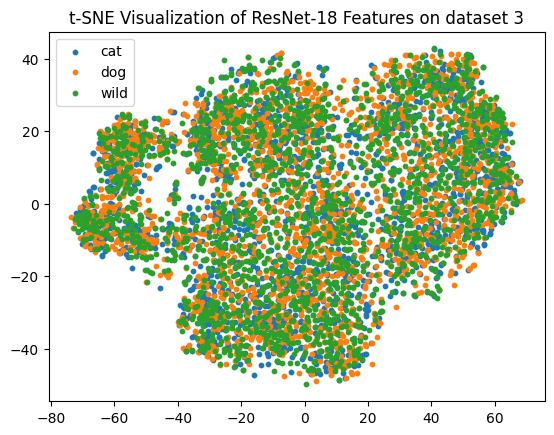

In [56]:
# Plot the t-SNE embeddings with different colors for each class
plt.scatter(embedded_features[all_labels == 0, 0], embedded_features[all_labels == 0, 1], label='cat',s=10)
plt.scatter(embedded_features[all_labels == 1, 0], embedded_features[all_labels == 1, 1], label='dog',s=10)
plt.scatter(embedded_features[all_labels == 2, 0], embedded_features[all_labels == 2, 1], label='wild',s=10)

plt.title('t-SNE Visualization of ResNet-18 Features on dataset 3')
plt.legend()
plt.show()

## Scenario 3: Pre-trained (ImageNet) CNN applied to dataset 2

Model declaration

In [44]:
net_pre=resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
net_pre.fc=nn.Linear(net_pre.fc.in_features,3)
features = list(net_pre.children())[:-1] #only remove fc
resnet_nohead = nn.Sequential(*features).to(device)
resnet_nohead = resnet_nohead.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 94.9MB/s]


In [45]:
all_features_pre_2 = []
all_labels_pre_2 = []

resnet_nohead.to(device)

with torch.no_grad():
    for images, labels in dataloader_sc1:
        images = images.to(device)
        labels = labels.to(device)
        features = resnet_nohead(images)
        features = features.squeeze().cpu().numpy()
        all_features_pre_2.append(features)
        all_labels_pre_2.append(labels.cpu().numpy())

# Concatenate features and labels
all_features_pre_2= np.concatenate(all_features_pre_2, axis=0)
all_labels_pre_2 = np.concatenate(all_labels_pre_2, axis=0)

In [46]:
tsne = TSNE(n_components=2, random_state=42)
embedded_features_pre_2 = tsne.fit_transform(all_features_pre_2)

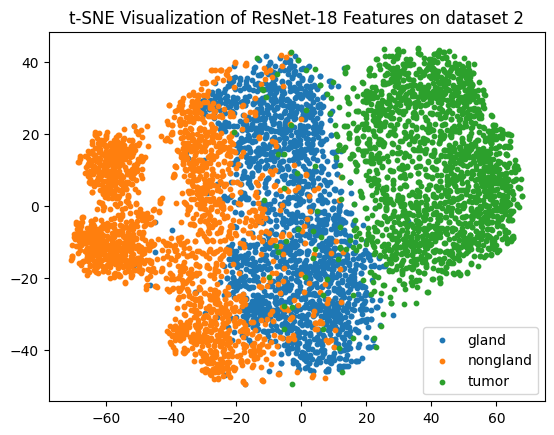

In [47]:
# Plot the t-SNE embeddings with different colors for each class
plt.scatter(embedded_features_pre_2[all_labels_pre_2 == 0, 0], embedded_features_pre_2[all_labels_pre_2 == 0, 1], label='gland', s=10)
plt.scatter(embedded_features_pre_2[all_labels_pre_2 == 1, 0], embedded_features_pre_2[all_labels_pre_2 == 1, 1], label='nongland', s=10)
plt.scatter(embedded_features_pre_2[all_labels_pre_2 == 2, 0], embedded_features_pre_2[all_labels_pre_2 == 2, 1], label='tumor', s=10)

plt.title('t-SNE Visualization of ResNet-18 Features on dataset 2')
plt.legend()
plt.show()

## Scenario 4: Pre-trained (ImageNet) CNN applied to dataset 3

In [48]:
all_features_pre_3 = []
all_labels_pre_3= []

resnet_nohead.to(device)

with torch.no_grad():
    for images, labels in dataloader_sc2:
        images = images.to(device)
        labels = labels.to(device)
        features = resnet_nohead(images)
        features = features.squeeze().cpu().numpy()
        all_features_pre_3.append(features)
        all_labels_pre_3.append(labels.cpu().numpy())

# Concatenate features and labels
all_features_pre_3= np.concatenate(all_features_pre_3, axis=0)
all_labels_pre_3 = np.concatenate(all_labels_pre_3, axis=0)

In [49]:
tsne = TSNE(n_components=2, random_state=42)
embedded_features_pre_3 = tsne.fit_transform(all_features_pre_3)

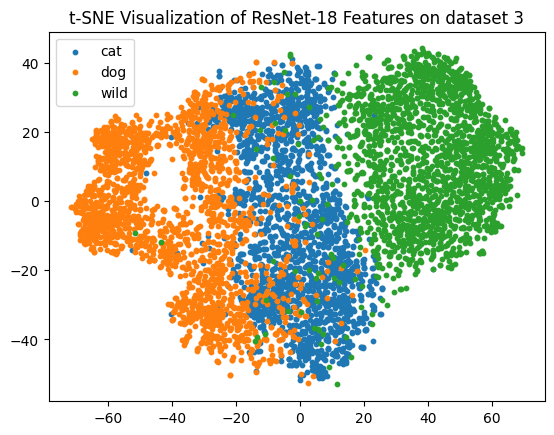

In [50]:
plt.scatter(embedded_features_pre_3[all_labels_pre_3 == 0, 0], embedded_features_pre_3[all_labels_pre_3 == 0, 1], label='cat',s=10)
plt.scatter(embedded_features_pre_3[all_labels_pre_3 == 1, 0], embedded_features_pre_3[all_labels_pre_3 == 1, 1], label='dog',s=10)
plt.scatter(embedded_features_pre_3[all_labels_pre_3 == 2, 0], embedded_features_pre_3[all_labels_pre_3 == 2, 1], label='wild',s=10)

plt.title('t-SNE Visualization of ResNet-18 Features on dataset 3')
plt.legend()
plt.show()